In [4]:
!pip install -e .. datasets sympy numpy matplotlib seaborn -q  # Install dev version of smolagents + some packages


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Constants and utilities/tools

In [2]:
# Benchmark date
# - set a concrete date:
DATE = "2024-12-26"
# - or use default: today
# DATE = None

# Evaluation dataset
# - the dataset is gated, so you must first visit its page to request access: https://huggingface.co/datasets/smolagents-benchmark/benchmark-v1
EVAL_DATASET = "smolagents/benchmark-v1"

# Answers dataset: it must be a gated dataset; required to score the answers
ANSWERS_DATASET = "smolagents/answers"
# Whether to push the answers dataset to the Hub
PUSH_ANSWERS_DATASET_TO_HUB = True

# Results dataset
RESULTS_DATASET = "smolagents/results"
# Whether to push the results dataset to the Hub
PUSH_RESULTS_DATASET_TO_HUB = True


import datetime
import json
import os
import re
import string
import time
import warnings
from typing import List

import datasets
from dotenv import load_dotenv
from tqdm import tqdm

from smolagents import (
    AgentError,
    CodeAgent,
    GoogleSearchTool,
    HfApiModel,
    PythonInterpreterTool,
    ToolCallingAgent,
    VisitWebpageTool,
)
from smolagents.agents import ActionStep


load_dotenv()
os.makedirs("output", exist_ok=True)


def serialize_agent_error(obj):
    if isinstance(obj, AgentError):
        return {"error_type": obj.__class__.__name__, "message": obj.message}
    else:
        return str(obj)


def answer_questions(
    eval_ds,
    agent,
    model_id,
    action_type,
    is_vanilla_llm=False,
    date=DATE,
    output_dir="output",
    push_to_hub_dataset=ANSWERS_DATASET if PUSH_ANSWERS_DATASET_TO_HUB else None,
):
    date = date or datetime.date.today().isoformat()

    for task in eval_ds:
        file_name = f"output/{model_id.replace('/', '__')}__{action_type}__{task}__{date}.jsonl"
        answered_questions = []
        if os.path.exists(file_name):
            with open(file_name, "r") as f:
                for line in f:
                    answered_questions.append(json.loads(line)["question"])

        for _, example in tqdm(enumerate(eval_ds[task]), total=len(eval_ds[task])):
            try:
                question = example["question"]
                if example["source"] == "SimpleQA":
                    question += " Answer with only the final number."
                if example["source"] == "MATH":
                    question += " Write code, not latex."
                if question in answered_questions:
                    continue
                start_time = time.time()

                if is_vanilla_llm:
                    llm = agent
                    answer = str(llm([{"role": "user", "content": question}]).content)
                    token_count = {
                        "input": llm.last_input_token_count,
                        "output": llm.last_output_token_count,
                    }
                    intermediate_steps = str([])
                else:
                    answer = str(agent.run(question))
                    token_count = agent.monitor.get_total_token_counts()
                    intermediate_steps = str(agent.logs)
                    # Remove memory from logs to make them more compact.
                    for step in agent.logs:
                        if isinstance(step, ActionStep):
                            step.agent_memory = None

                end_time = time.time()
                annotated_example = {
                    "model_id": model_id,
                    "agent_action_type": action_type,
                    "question": question,
                    "answer": answer,
                    "true_answer": example["true_answer"],
                    "source": example["source"],
                    "intermediate_steps": intermediate_steps,
                    "start_time": start_time,
                    "end_time": end_time,
                    "token_counts": token_count,
                }

                with open(file_name, "a") as f:
                    json.dump(annotated_example, f, default=serialize_agent_error)
                    f.write("\n")  # add a newline for JSONL format
            except Exception as e:
                print("Failed:", e)

        if push_to_hub_dataset:
            ds = datasets.Dataset.from_pandas(pd.read_json(file_name, lines=True), split="test", preserve_index=False)
            config = f"{model_id.replace('/', '__')}__{action_type}__{task}"
            data_dir = f"{model_id}/{action_type}/{task}/{date}"
            ds.push_to_hub(
                push_to_hub_dataset,
                config_name=config,
                data_dir=data_dir,
                split="test",
                commit_message=f"Upload {config}",
            )


def normalize_number_str(number_str: str) -> float:
    # we replace these common units and commas to allow
    # conversion to float
    for char in ["$", "%", ","]:
        number_str = number_str.replace(char, "")
    try:
        return float(number_str)
    except ValueError:
        return float("inf")


def split_string(
    s: str,
    char_list: list[str] = [",", ";"],
) -> list[str]:
    pattern = f"[{''.join(char_list)}]"
    return re.split(pattern, s)


def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False


def normalize_str(input_str, remove_punct=True) -> str:
    """
    Normalize a string by:
    - Removing all white spaces
    - Optionally removing punctuation (if remove_punct is True)
    - Converting to lowercase
    Parameters:
    - input_str: str, the string to normalize
    - remove_punct: bool, whether to remove punctuation (default: True)
    Returns:
    - str, the normalized string
    """
    # Remove all white spaces. Required e.g for seagull vs. sea gull
    no_spaces = re.sub(r"\s", "", input_str)

    # Remove punctuation, if specified.
    if remove_punct:
        translator = str.maketrans("", "", string.punctuation)
        return no_spaces.lower().translate(translator)
    else:
        return no_spaces.lower()


def extract_numbers(text: str) -> List[str]:
    """This pattern matches:
    - Optional negative sign
    - Numbers with optional comma thousand separators
    - Optional decimal points with decimal numbers
    """
    pattern = r"-?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?"

    return [el.replace(",", "") for el in re.findall(pattern, text)]


def get_question_score_gaia(
    model_answer: str,
    ground_truth: str,
) -> bool:
    """Scoring function used to score functions from the GAIA benchmark"""
    if is_float(ground_truth):
        normalized_answer = normalize_number_str(str(model_answer))
        return normalized_answer == float(ground_truth)

    elif any(char in ground_truth for char in [",", ";"]):  # if gt is a list
        # question with the fish: normalization removes punct
        gt_elems = split_string(ground_truth)
        ma_elems = split_string(model_answer)

        if len(gt_elems) != len(ma_elems):  # check length is the same
            warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
            return False

        comparisons = []
        for ma_elem, gt_elem in zip(ma_elems, gt_elems):  # compare each element as float or str
            if is_float(gt_elem):
                normalized_ma_elem = normalize_number_str(ma_elem)
                comparisons.append(normalized_ma_elem == float(gt_elem))
            else:
                # we do not remove punct since comparisons can include punct
                comparisons.append(
                    normalize_str(ma_elem, remove_punct=False) == normalize_str(gt_elem, remove_punct=False)
                )
        return all(comparisons)

    else:  # if gt is a str
        return normalize_str(model_answer) == normalize_str(ground_truth)


def get_correct(row):
    if row["source"] == "MATH":  # Checks the last number in answer
        numbers_answer = extract_numbers(str(row["answer"]))
        if len(numbers_answer) == 0:
            return False
        return float(numbers_answer[-1]) == float(row["true_answer"])
    else:
        return get_question_score_gaia(str(row["answer"]), str(row["true_answer"]))


def score_answers(
    answers_subsets,
    answers_dataset=ANSWERS_DATASET,
    date=DATE,
    push_to_hub_dataset=RESULTS_DATASET if PUSH_RESULTS_DATASET_TO_HUB else None,
    set_default=True,
):
    if not answers_dataset:
        raise ValueError("Pass 'answers_dataset' to load the answers from it")
    date = date or datetime.date.today().isoformat()
    results = []
    for answers_subset in answers_subsets:
        *model_id, action_type, task = answers_subset.split("__")
        model_id = "/".join(model_id)
        ds = datasets.load_dataset(answers_dataset, answers_subset, split="test")
        df = ds.to_pandas()
        df["correct"] = df.apply(get_correct, axis=1)
        acc = df["correct"].mean().item()
        result = df.loc[0, ["model_id", "agent_action_type", "source"]].to_dict()
        result["acc"] = acc
        results.append(result)
    df = pd.DataFrame(results)
    df["agent_action_type"] = df["agent_action_type"].str.replace("tool_calling", "tool-calling")

    if push_to_hub_dataset:
        ds = datasets.Dataset.from_pandas(df)
        config = date
        set_default = set_default
        ds.push_to_hub(
            push_to_hub_dataset, config_name=config, set_default=set_default, commit_message=f"Upload {config} results"
        )
    return df

## Evaluation dataset

In [3]:
import pandas as pd


# Choose the tasks to evaluate on:
# tasks = ["gaia"]
# or evaluate on all tasks: ["gaia", "math", "simpleqa"]
tasks = datasets.get_dataset_config_names(EVAL_DATASET)
print(tasks)


eval_ds = {task: datasets.load_dataset(EVAL_DATASET, task, split="test") for task in tasks}
pd.DataFrame(eval_ds["simpleqa"]).head()

['gaia', 'math', 'simpleqa']


,question,source,true_answer,true_reasoning
0,"What year was the municipality of Ramiriquí, B...",SimpleQA,1541,['https://en.wikipedia.org/wiki/Ramiriqu%C3%AD...
1,In what year did Hjalmar Hvam invent a mechani...,SimpleQA,1937,['https://www.kgw.com/article/features/portlan...
2,In which year did Fayaz A. Malik (an Indian ph...,SimpleQA,2009,['https://en.wikipedia.org/wiki/Fayaz_A._Malik...
3,In which year was John B. Goodenough elected a...,SimpleQA,2010,['https://en.wikipedia.org/wiki/John_B._Gooden...
4,In which year did Atul Gawande earn an M.A. in...,SimpleQA,1989,"['https://en.wikipedia.org/wiki/Atul_Gawande',..."


## Benchmark agents

### Open models

In [ ]:
open_model_ids = [
    "meta-llama/Llama-3.3-70B-Instruct",
    # "Qwen/QwQ-32B-Preview",
    "Qwen/Qwen2.5-72B-Instruct",
    "Qwen/Qwen2.5-Coder-32B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
    "mistralai/Mistral-Nemo-Instruct-2407",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    # "meta-llama/Llama-3.1-70B-Instruct",
]


for model_id in open_model_ids:
    print(f"Evaluating '{model_id}'...")
    # action_type = "tool-calling"
    # agent = ToolCallingAgent(
    #     tools=[GoogleSearchTool(), VisitWebpageTool(), PythonInterpreterTool()],
    #     model=HfApiModel(model_id),
    #     max_steps=10,
    # )
    # answer_questions(eval_ds, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        model=HfApiModel(model_id),
        additional_authorized_imports=["numpy", "sympy"],
        max_steps=10,
    )
    answer_questions(eval_ds, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = HfApiModel(model_id)
    answer_questions(eval_ds, llm, model_id, action_type, is_vanilla_llm=True)

### Closed models

In [ ]:
from smolagents import LiteLLMModel


litellm_model_ids = ["gpt-4o", "anthropic/claude-3-5-sonnet-latest"]


for model_id in litellm_model_ids:
    print(f"Evaluating '{model_id}'...")
    action_type = "tool-calling"
    agent = ToolCallingAgent(
        tools=[
            GoogleSearchTool(),
            VisitWebpageTool(),
            PythonInterpreterTool(["numpy", "sympy"]),
        ],
        model=LiteLLMModel(model_id),
        max_steps=10,
    )
    answer_questions(eval_ds, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        model=LiteLLMModel(model_id),
        additional_authorized_imports=["numpy", "sympy"],
        max_steps=10,
    )
    answer_questions(eval_ds, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = LiteLLMModel(model_id)
    answer_questions(eval_ds, llm, model_id, action_type, is_vanilla_llm=True)

In [8]:
# import glob
# import json

# jsonl_files = glob.glob(f"output/*.jsonl")

# for file_path in jsonl_files:
#     if "-Nemo-" in file_path and "-vanilla-" in file_path:
#         print(file_path)
#         # Read all lines and filter out SimpleQA sources
#         filtered_lines = []
#         removed = 0
#         with open(file_path, "r", encoding="utf-8") as f:
#             for line in f:
#                 try:
#                     data = json.loads(line.strip())
#                     data["answer"] = data["answer"]["content"]
#                     # if not any([question in data["question"] for question in eval_ds["question"]]):
#                     #     removed +=1
#                     # else:
#                     filtered_lines.append(json.dumps(data) + "\n")
#                 except json.JSONDecodeError:
#                     print("Invalid line:", line)
#                     continue  # Skip invalid JSON lines
#         print(f"Removed {removed} lines.")
#         # Write filtered content back to the same file
#         with open(
#             str(file_path).replace("-vanilla-", "-vanilla2-"), "w", encoding="utf-8"
#         ) as f:
#             f.writelines(filtered_lines)

## Score answers

In [4]:
import datasets
import pandas as pd


# Choose the answers subsets to score:
# answers_subsets = ["meta-llama__Llama-3.1-8B-Instruct__code__gaia"]
# or get all the answers subsets present in the ANSWERS_DATASET
answers_subsets = datasets.get_dataset_config_names(ANSWERS_DATASET)
print("Number of answers_subsets", len(answers_subsets))
print("Example of answers_subset", answers_subsets[0])

Number of answers_subsets 84
Example of answers_subset Qwen__Qwen2.5-72B-Instruct__code__gaia


In [5]:
result_df = score_answers(answers_subsets)
result_df["acc"] = (result_df["acc"] * 100).round(2)
result_df.head()

Generating test split: 100%|██████████| 32/32 [00:00<00:00, 2747.66 examples/s]
/var/folders/6m/9b1tts6d5w960j80wbw9tx3m0000gn/T/ipykernel_7591/2098693032.py:215: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Generating test split: 100%|██████████| 32/32 [00:00<00:00, 9176.65 examples/s]
/var/folders/6m/9b1tts6d5w960j80wbw9tx3m0000gn/T/ipykernel_7591/2098693032.py:215: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Generating test split: 100%|██████████| 32/32 [00:00<00:00, 2768.17 examples/s]
/var/folders/6m/9b1tts6d5w960j80wbw9tx3m0000gn/T/ipykernel_7591/2098693032.py:215: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Generating test split: 100%|██████████| 32/32 [00:00

NonMatchingSplitsSizesError: [{'expected': SplitInfo(name='test', num_bytes=4527563, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]

In [12]:
pivot_df = result_df.pivot_table(
    index=["model_id", "source"],
    columns=["agent_action_type"],
    values="acc",
    fill_value=float("nan"),
).reset_index()

### Display results

In [13]:
display(pivot_df)

agent_action_type,model_id,source,code,tool-calling,vanilla
0,Qwen/Qwen2.5-72B-Instruct,GAIA,28.12,NaN,6.25
1,Qwen/Qwen2.5-72B-Instruct,MATH,76.00,NaN,30.00
2,Qwen/Qwen2.5-72B-Instruct,SimpleQA,88.00,NaN,10.00
3,Qwen/Qwen2.5-Coder-32B-Instruct,GAIA,21.88,18.75,3.12
4,Qwen/Qwen2.5-Coder-32B-Instruct,MATH,84.00,44.00,62.00
5,Qwen/Qwen2.5-Coder-32B-Instruct,SimpleQA,74.00,58.00,8.00
6,anthropic/claude-3-5-sonnet-latest,GAIA,56.25,0.00,3.12
7,anthropic/claude-3-5-sonnet-latest,MATH,82.00,54.00,50.00
8,anthropic/claude-3-5-sonnet-latest,SimpleQA,82.00,0.00,34.00
9,deepseek-ai/DeepSeek-R1,GAIA,0.00,0.00,NaN


AttributeError: Rectangle.set() got an unexpected keyword argument 'hatch_linewidth'

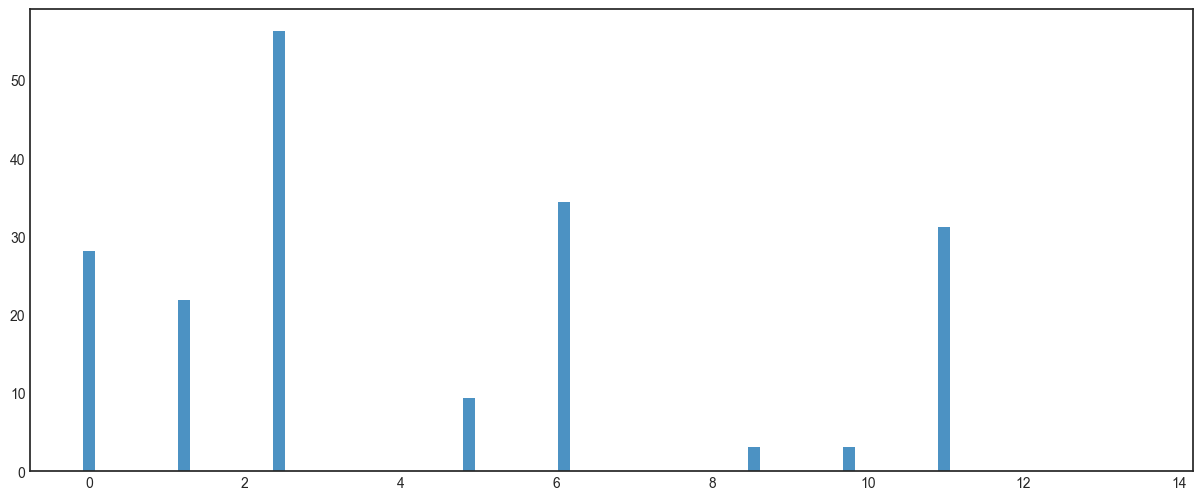

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerTuple  # Added import


# Assuming pivot_df is your original dataframe
models = pivot_df["model_id"].unique()
sources = pivot_df["source"].unique()

# Create figure and axis
plt.style.use("seaborn-v0_8-white")
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of each bar group and positions of the bars
width = 0.15  # width of each bar
spacing = 0.02  # space between bars within a group
group_spacing = 0.2  # space between model groups

# Calculate positions for the bars
num_sources = len(sources)
total_width_per_group = (width + spacing) * num_sources * 2  # *2 for agent and vanilla
x = np.arange(len(models)) * (total_width_per_group + group_spacing)

# Plot bars for each source
for i, source in enumerate(sources):
    source_data = pivot_df[pivot_df["source"] == source]
    agent_scores = [
        source_data[source_data["model_id"] == model]["code"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]
    vanilla_scores = [
        source_data[source_data["model_id"] == model]["vanilla"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]

    # Position calculation for each pair of bars
    pos = x + i * (width * 2 + spacing)

    agent_bars = ax.bar(pos, agent_scores, width, label=f"{source} (Agent)", alpha=0.8)
    vanilla_bars = ax.bar(
        pos + width * 0.6,
        vanilla_scores,
        width,
        hatch="////",
        alpha=0.5,
        hatch_linewidth=2,
        label=f"{source} (Vanilla)",
        color="white",
        edgecolor=agent_bars[0].get_facecolor(),
    )

# Customize the plot
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")

# Set x-axis ticks in the middle of each group
group_centers = x + (total_width_per_group - spacing) / 2
ax.set_xticks(group_centers)

# Wrap long model names to prevent overlap
wrapped_labels = ["\n".join(model.split("/")) for model in models]
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Modify legend to combine agent and vanilla entries
handles, labels = ax.get_legend_handles_labels()
unique_sources = sources
legend_elements = [
    (handles[i * 2], handles[i * 2 + 1], labels[i * 2].replace(" (Agent)", "")) for i in range(len(unique_sources))
]
custom_legend = ax.legend(
    [(agent_handle, vanilla_handle) for agent_handle, vanilla_handle, _ in legend_elements],
    [label for _, _, label in legend_elements],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [ ]:
def create_mathjax_table(pivot_df, formatted_df):
    # Start the matrix environment with 4 columns
    # l for left-aligned model and task, c for centered numbers
    mathjax_table = "\\begin{array}{llcc}\n"
    mathjax_table += "\\text{Model} & \\text{Task} & \\text{Agent} & \\text{Vanilla} \\\\\n"
    mathjax_table += "\\hline\n"

    # Sort the DataFrame by model_id and source
    formatted_df = formatted_df.sort_values(["model_id", "source"])

    current_model = None
    for _, row in formatted_df.iterrows():
        model = row["model_id"]
        source = row["source"]

        # Add a horizontal line between different models
        if current_model is not None and current_model != model:
            mathjax_table += "\\hline\n"

        # Format model name
        model_display = model.replace("_", "\\_")
        if "Qwen" in model or "anthropic" in model:
            model_display = f"\\textit{{{model_display}}}"

        # If it's the same model as previous row, use empty space
        if current_model == model:
            model_display = "\\;"

        # Add the data row
        mathjax_table += f"{model_display} & {source} & {row['agent']} & {row['vanilla']} \\\\\n"

        current_model = model

    mathjax_table += "\\hline\n"
    mathjax_table += "\\end{array}"

    return mathjax_table


# Usage (after running your previous data processing code):
# mathjax_table = create_mathjax_table(pivot_df, formatted_df)
# print(mathjax_table)

NameError: name 'formatted_df' is not defined